Start with Extracting the dataset on colab,
Kaggle does not require this step

In [ ]:
import zipfile

zip_file_path = '/content/deep-learning-spring-2025-project-1.zip'
destination_folder = 'Dataset'

with zipfile.ZipFile(zip_file_path, 'r') as z:
    z.extractall(destination_folder)

print(f"Files extracted to: {destination_folder}")

Files extracted to: Dataset


Going through the files from the parent directory

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/content/Dataset/cifar_test_nolabel.pkl
/content/Dataset/cifar-10-python/cifar-10-batches-py/test_batch
/content/Dataset/cifar-10-python/cifar-10-batches-py/data_batch_4
/content/Dataset/cifar-10-python/cifar-10-batches-py/data_batch_1
/content/Dataset/cifar-10-python/cifar-10-batches-py/data_batch_5
/content/Dataset/cifar-10-python/cifar-10-batches-py/batches.meta
/content/Dataset/cifar-10-python/cifar-10-batches-py/readme.html
/content/Dataset/cifar-10-python/cifar-10-batches-py/data_batch_3
/content/Dataset/cifar-10-python/cifar-10-batches-py/data_batch_2


unpickle using the snipet provided
Also run a loop to get all the 5 batches done
and then printing classes, total number of images and label

In [ ]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

classes_dict = unpickle("/content/Dataset/cifar-10-python/cifar-10-batches-py/batches.meta")
label_names = classes_dict[b'label_names']
print(label_names)

# Load training data in batches, then combine
training_data = []
training_labels = []
for i in range(1, 6):
    training_fp = "/content/Dataset/cifar-10-python/cifar-10-batches-py/data_batch_{}".format(i)
    batch = unpickle(training_fp)
    batch_data = batch[b'data']
    batch_labels = batch[b'labels']
    for i in range(len(batch_data)):
        training_data.append(batch_data[i])
        training_labels.append(batch_labels[i])

print(len(training_data))
print(len(training_labels))

[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']
50000
50000


Initially we just had a common transformation applies to both the train and validation set, but halfway through we decided that we don't want to test on transformed data so these functions might appear slighly different in earlier versions.

In [ ]:
import numpy as np
from torchvision import transforms
from PIL import Image

# Assuming training_labels is a NumPy array
training_labels = np.array(training_labels)

def transform_image(image):
    transform = transforms.Compose([
        transforms.ToPILImage(),  # Convert tensor to PIL for augmentation
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), value=1.0, inplace=False),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalization
    ])
    return transform(image)

def transform_validation(image):
    valid_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return valid_transform(image)

# Convert and reshape training data
training_data = np.array(training_data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

# Split data into training and validation sets
training_count = int(0.8 * len(training_data))
validation_count = len(training_data) - training_count  # To make sure the total count adds up

# Apply random_split on training data and corresponding labels
train_data, val_data = random_split(list(zip(training_data, training_labels)), [training_count, validation_count])

# Apply transformations to training and validation data
training_data = [(transform_image(image), label) for image, label in train_data]
validation_data = [(transform_validation(image), label) for image, label in val_data]

print(training_data[0][0].shape)  # Training data
print(validation_data[0][0].shape)  # Validation data


torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


Defining the NN here.
I went with 2 sorts of residual blocks eventually, even though most of our work employes a single type.
The idea is derived from the fact that while training I could either let my model overfit and that was the only case where the architecture would completely learn the data (100% on train), if I took any measures to prevent the overfitting, be it L1 or L2 regularisation or playing aaround with learning rates or scheduling learning rates or even batch size, the model would struggle to learn and would bottleneck at about 80% train and 70-75% validation accuracy.

This made me think there are some sort of features that I am missing out on and hence I tried creating two sorts of blocks, Global and Local

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Global Feature Residual Block (Dilated Convolutions)
class GlobalResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dilation=2):
        super(GlobalResidualBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out += self.shortcut(x)  # skip connection
        out = self.relu(out)
        return self.dropout(out)

# Local Feature Residual Block (Depthwise Separable Convolutions)
class LocalResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(LocalResidualBlock, self).__init__()
        self.depthwise_conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, bias=False)
        self.pointwise_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        out = self.depthwise_conv(x)
        out = self.pointwise_conv(out)
        out = self.bn(out)
        out += self.shortcut(x)  # skip connection
        out = self.relu(out)
        return self.dropout(out)

# Simple ResNet with Global & Local Blocks
class SimpleResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Using Global and Local Residual Blocks
        self.layer1 = GlobalResidualBlock(64, 64, stride=1)  # Global Features
        self.layer2 = LocalResidualBlock(64, 64, stride=2)  # Local Features
        self.layer3 = GlobalResidualBlock(64, 128, stride=2)  # Global Features
        self.layer4 = LocalResidualBlock(128, 128, stride=2)  # local Features
        self.layer5 = GlobalResidualBlock(128, 128, stride=2)  # Global Features
        self.layer6 = LocalResidualBlock(128, 256, stride=2)  # Local Features
        self.layer8 = LocalResidualBlock(256, 256, stride=2)  # local Features
        self.layer9 = LocalResidualBlock(256, 512, stride=2)  # local Features
        self.layer10 = LocalResidualBlock(512, 512, stride=2)  # local Features
        self.layer11 = GlobalResidualBlock(512, 512, stride=2)  # Global Features
        self.layer12 = LocalResidualBlock(512, 512, stride=2)  # local Features

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.avg_pool(out)
        out = self.dropout(out)
        out = torch.flatten(out, 1)
        return self.fc(out)

# Model Summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleResNet(num_classes=10).to(device)
print(model)


SimpleResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): GlobalResidualBlock(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
    (relu): ReLU(inplace=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (layer2): LocalResidualBlock(
    (depthwise_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
    (pointwise_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(

Made sure the parameters are below 5M, tested several architectures ranging from 75K params to 4.9M params (All available on github repo)

In [ ]:
import torch.optim as optim
# Create an instance of the model
model = SimpleResNet()

# Print total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 4488202


In [ ]:
import torch.optim as optim
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleResNet().to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
           Dropout-7           [-1, 64, 32, 32]               0
GlobalResidualBlock-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 16, 16]             576
           Conv2d-10           [-1, 64, 16, 16]           4,096
      BatchNorm2d-11           [-1, 64, 16, 16]             128
           Conv2d-12           [-1, 64, 16, 16]           4,096
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64

It is hard to tell a story using just this block alone, but if you go through the notebooks on github, we tried a bunch of stuff in our training loops and ill list them here
1. optimisers (Adam and SGD)
2. Learning rate scheduling (Cyclic, plateau, cosine annealing, Multistep)
3. Regularisation (Dropout L1 and decay L2)

Epoch 1: Training Loss: 1.9764, Training Accuracy: 27.21%, Validation Accuracy: 42.44%
Epoch 2: Training Loss: 1.7012, Training Accuracy: 38.01%, Validation Accuracy: 47.99%
Epoch 3: Training Loss: 1.5991, Training Accuracy: 41.74%, Validation Accuracy: 51.75%
Epoch 4: Training Loss: 1.5234, Training Accuracy: 44.98%, Validation Accuracy: 54.32%
Epoch 5: Training Loss: 1.4506, Training Accuracy: 48.16%, Validation Accuracy: 57.24%
Epoch 6: Training Loss: 1.3887, Training Accuracy: 50.57%, Validation Accuracy: 59.78%
Epoch 7: Training Loss: 1.3404, Training Accuracy: 52.90%, Validation Accuracy: 59.95%
Epoch 8: Training Loss: 1.2903, Training Accuracy: 54.77%, Validation Accuracy: 62.22%
Epoch 9: Training Loss: 1.2533, Training Accuracy: 55.91%, Validation Accuracy: 63.62%
Epoch 10: Training Loss: 1.2135, Training Accuracy: 57.63%, Validation Accuracy: 63.82%
Epoch 11: Training Loss: 1.1711, Training Accuracy: 59.19%, Validation Accuracy: 64.59%
Epoch 12: Training Loss: 1.1498, Training

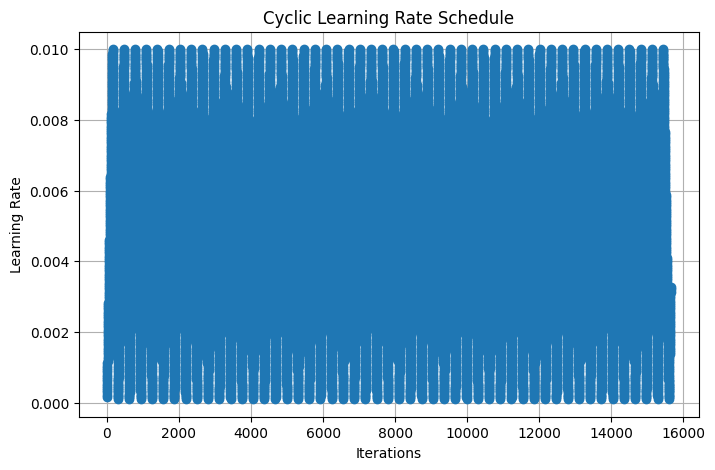

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-6)
optimizer = optim.Adam(model.parameters(), lr=0.01) #not using L2 anymore although it works better with sgd


# DataLoaders
training_loader = DataLoader(training_data, batch_size=128, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_data, batch_size=128, shuffle=False, num_workers=4)


scheduler = optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=0.0001,  # Lower bound of LR
    max_lr=0.01,     # Upper bound of LR
    step_size_up=len(training_loader) // 2,  # Half an epoch
    mode='triangular',  # More stable than triangular2
    cycle_momentum=False  # Turn off momentum updates if using Adam
)

# Store learning rates
lr_history = []

# Training loop
num_epochs = 50
for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    total_train_predictions = 0
    total_train_correct = 0

    for images, labels in training_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()  # Update learning rate after each batch

        running_loss += loss.item()
        _, predictions = torch.max(outputs, dim=1)
        total_train_correct += (predictions == labels).sum().item()
        total_train_predictions += labels.size(dim=0)

        # Store current learning rate
        lr_history.append(scheduler.get_last_lr()[0])

    # Validation phase
    model.eval()
    total_val_predictions = 0
    total_val_correct = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predictions = torch.max(outputs, dim=1)
            total_val_correct += (predictions == labels).sum().item()
            total_val_predictions += labels.size(dim=0)

    val_acc = total_val_correct * 100 / total_val_predictions
    train_acc = total_train_correct * 100 / total_train_predictions
    train_loss = running_loss / len(training_loader)

    print(f'Epoch {epoch+1}: Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%')

print("Training complete!")

# Plot learning rate changes
plt.figure(figsize=(8, 5))
plt.plot(lr_history, marker='o', linestyle='-')
plt.xlabel('Iterations')
plt.ylabel('Learning Rate')
plt.title('Cyclic Learning Rate Schedule')
plt.grid(True)
plt.show()


Since you can see it just gets stuck around the 80% mark due to the overfitting measures I took (this is at a point I have tried everything I can think of and it's some hours before final submission)
The idea here is to freeze the weight of local blocks, this is because the local features don't get affected using the transformations such as cropping or rotating, but the global features do, so apply transformations on all the data and try training only the global features.
This is a very naive start to the idea and could be explored further and experimented upon

So, starting with loading the data over again

In [ ]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

classes_dict = unpickle("/content/Dataset/cifar-10-python/cifar-10-batches-py/batches.meta")
label_names = classes_dict[b'label_names']
print(label_names)

# Load training data in batches, then combine
training_data = []
training_labels = []
for i in range(1, 6):
    training_fp = "/content/Dataset/cifar-10-python/cifar-10-batches-py/data_batch_{}".format(i)
    batch = unpickle(training_fp)
    batch_data = batch[b'data']
    batch_labels = batch[b'labels']
    for i in range(len(batch_data)):
        training_data.append(batch_data[i])
        training_labels.append(batch_labels[i])

print(len(training_data))
print(len(training_labels))

[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']
50000
50000


Apply transformations on all the data this time

In [ ]:
training_labels = np.array(training_labels)

def transform_image(image):
    image = transforms.ToPILImage()(image) # Required for plt display
    image = transforms.RandomHorizontalFlip()(image)
    image = transforms.RandomRotation(15)(image)
    image = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)(image)
    image = transforms.RandomResizedCrop(32, scale=(0.8, 1.0))(image)
    image = transforms.ToTensor()(image)
    image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image) # common mean / std. dev numbers cited in Pytorch docs
    return image

print(training_data[0].shape)
# Reshape the array to (N, 3, 32, 32), then rearrange to (N, 32, 32, 3) for transformations
training_data = np.array(training_data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
print(training_data[0].shape)

training_data = [(transform_image(image), label) for image, label in zip(training_data, training_labels)]
print(training_data[0][0].shape)

(3072,)
(32, 32, 3)
torch.Size([3, 32, 32])


In [ ]:
training_count = int(0.8 * len(training_data))
validation_count = int(0.2 * len(training_data))

training_data, validation_data = random_split(training_data, [training_count, validation_count])

Save the model

In [ ]:
torch.save(model.state_dict(), "model_weights.pth")

Load the model

In [ ]:
model.load_state_dict(torch.load("model_weights.pth"))
model.to(device)

<ipython-input-27-3b73b9aa1e6b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_weights.pth"))


SimpleResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): GlobalResidualBlock(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
    (relu): ReLU(inplace=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (layer2): LocalResidualBlock(
    (depthwise_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
    (pointwise_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(

Freeze the local blocks

In [ ]:
for layer in [model.layer2, model.layer4, model.layer6, model.layer8, model.layer9, model.layer10, model.layer12]:  # 2 4 6 8 9 10 12 local blocks
    for param in layer.parameters():
        param.requires_grad = False


Verify

In [ ]:
for name, param in model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")


conv1.weight: Trainable
bn1.weight: Trainable
bn1.bias: Trainable
layer1.conv.weight: Trainable
layer1.bn.weight: Trainable
layer1.bn.bias: Trainable
layer2.depthwise_conv.weight: Frozen
layer2.pointwise_conv.weight: Frozen
layer2.bn.weight: Frozen
layer2.bn.bias: Frozen
layer2.shortcut.0.weight: Frozen
layer2.shortcut.1.weight: Frozen
layer2.shortcut.1.bias: Frozen
layer3.conv.weight: Trainable
layer3.bn.weight: Trainable
layer3.bn.bias: Trainable
layer3.shortcut.0.weight: Trainable
layer3.shortcut.1.weight: Trainable
layer3.shortcut.1.bias: Trainable
layer4.depthwise_conv.weight: Frozen
layer4.pointwise_conv.weight: Frozen
layer4.bn.weight: Frozen
layer4.bn.bias: Frozen
layer4.shortcut.0.weight: Frozen
layer4.shortcut.1.weight: Frozen
layer4.shortcut.1.bias: Frozen
layer5.conv.weight: Trainable
layer5.bn.weight: Trainable
layer5.bn.bias: Trainable
layer5.shortcut.0.weight: Trainable
layer5.shortcut.1.weight: Trainable
layer5.shortcut.1.bias: Trainable
layer6.depthwise_conv.weight: Fr

Now train on the new model with local blocks frozen

Epoch 1: Training Loss: 1.0269, Training Accuracy: 66.39%, Validation Accuracy: 70.63%
Epoch 2: Training Loss: 0.9356, Training Accuracy: 68.18%, Validation Accuracy: 71.48%
Epoch 3: Training Loss: 0.8936, Training Accuracy: 69.67%, Validation Accuracy: 71.51%
Epoch 4: Training Loss: 0.8589, Training Accuracy: 70.79%, Validation Accuracy: 71.80%
Epoch 5: Training Loss: 0.8302, Training Accuracy: 71.68%, Validation Accuracy: 71.62%
Epoch 6: Training Loss: 0.8012, Training Accuracy: 72.89%, Validation Accuracy: 71.50%
Epoch 7: Training Loss: 0.7806, Training Accuracy: 73.59%, Validation Accuracy: 72.09%
Epoch 8: Training Loss: 0.7576, Training Accuracy: 74.18%, Validation Accuracy: 71.72%
Epoch 9: Training Loss: 0.7389, Training Accuracy: 74.97%, Validation Accuracy: 72.16%
Epoch 10: Training Loss: 0.7210, Training Accuracy: 75.52%, Validation Accuracy: 71.96%
Epoch 11: Training Loss: 0.7006, Training Accuracy: 76.11%, Validation Accuracy: 71.63%
Epoch 12: Training Loss: 0.6835, Training

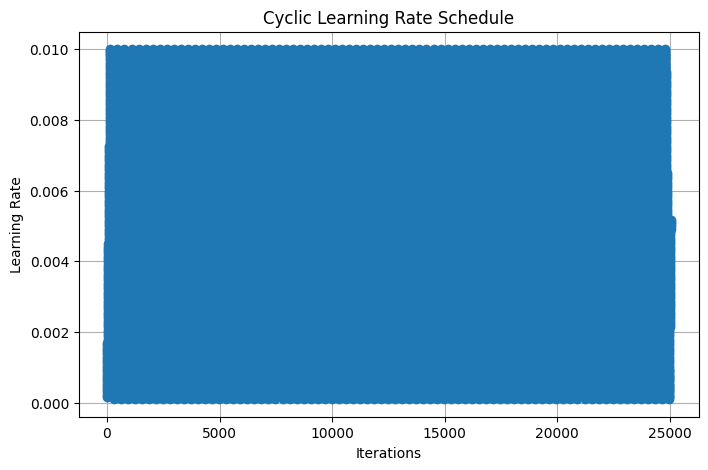

In [ ]:
# Define Loss and Optimizer Only for Unfrozen Layers
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01)

training_loader = DataLoader(training_data, batch_size=128, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_data, batch_size=128, shuffle=False, num_workers=4)

# Cyclic Learning Rate Scheduler
scheduler = optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=0.0001,
    max_lr=0.01,
    step_size_up=len(training_loader) // 2,
    mode='triangular',
    cycle_momentum=False
)

# Store learning rates
lr_history = []

# Training loop
num_epochs = 80
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_train_predictions = 0
    total_train_correct = 0

    for images, labels in training_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()  # Updates only unfrozen layers now
        scheduler.step()  # Update learning rate after each batch

        running_loss += loss.item()
        _, predictions = torch.max(outputs, dim=1)
        total_train_correct += (predictions == labels).sum().item()
        total_train_predictions += labels.size(dim=0)

        # Store current learning rate
        lr_history.append(scheduler.get_last_lr()[0])

    # Validation phase
    model.eval()
    total_val_predictions = 0
    total_val_correct = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predictions = torch.max(outputs, dim=1)
            total_val_correct += (predictions == labels).sum().item()
            total_val_predictions += labels.size(dim=0)

    val_acc = total_val_correct * 100 / total_val_predictions
    train_acc = total_train_correct * 100 / total_train_predictions
    train_loss = running_loss / len(training_loader)

    print(f'Epoch {epoch+1}: Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%')

print("Training complete!")

# Plot learning rate changes
plt.figure(figsize=(8, 5))
plt.plot(lr_history, marker='o', linestyle='-')
plt.xlabel('Iterations')
plt.ylabel('Learning Rate')
plt.title('Cyclic Learning Rate Schedule')
plt.grid(True)
plt.show()


getting the unlabelled test set ready

In [ ]:
# Load test dataset
testing_fp = '/content/Dataset/cifar_test_nolabel.pkl'
testing_batch = unpickle(testing_fp)
testing_data = testing_batch[b'data']

print(testing_data[0].shape)

(32, 32, 3)


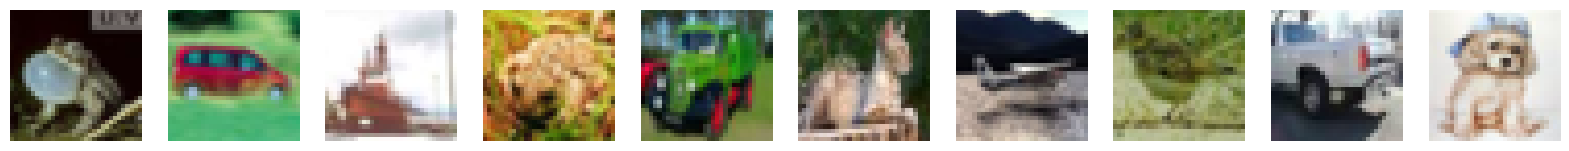

In [ ]:
# Displaying the first 10 images, since we can't see the labels
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(testing_data[i])
    plt.axis('off')
plt.show()

# [0: airplane, 1: automobile, 2: bird, 3: cat, 4: deer, 5: dog, 6: frog, 7: horse, 8: ship, 9: truck]
# So we should expect [6, 1, 8, 6, 9, 7, 8, 2, 9, 5] as the first 10 entries of our final CSV.

In [ ]:
# Changing to Tensor and adjusting shape before test
testing_data = [(transform_validation(image),) for image in testing_data]
print(testing_data[0][0].shape)

# DataLoader
testing_loader = DataLoader(testing_data, batch_size=128, shuffle=False)

torch.Size([3, 32, 32])


extract a csv

In [ ]:
## Final output is file called submission.csv with columns ID, Labels

model.eval()
test_predictions = []

with torch.no_grad():
    for batch in testing_loader:
        images = batch[0].to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, dim=1)
        test_predictions.extend(predictions.cpu().numpy())

test_predictions_dict = {'ID': np.arange(len(test_predictions)), 'Labels': test_predictions}
test_predictions_df = pd.DataFrame(test_predictions_dict)
test_predictions_df.to_csv('submission1.csv', index=False)
print("Submitted! Check output for submission.csv")

Submitted! Check output for submission.csv
